In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_regression
from sklearn.naive_bayes import BernoulliNB # Naive Gaus
from sklearn.preprocessing import OneHotEncoder # Conditional Probability 
import shap
from itertools import product

In [2]:
# Setup
df = pd.read_csv('Mental_Health_dataset1.csv')
df.drop('SocialWeakness.1', axis=1, inplace=True)
DropCountries = ['Bosnia and Herzegovina', 'Brazil', 'Colombia', 'Costa Rica', 'Croatia', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Israel', 'Italy', 'Mexico', 'Moldova', 'Nigeria', 'Philippines', 'Portugal', 'Russia', 'Singapore', 'Switzerland', 'Thailand']
df = df[~df['Country'].isin(DropCountries)]
df.dropna()
df.describe()

,Gender,Country,Occupation,SelfEmployed,FamilyHistory,Treatment,DaysIndoors,HabitsChange,MentalHealthHistory,IncreasingStress,MoodSwings,SocialWeakness,CopingStruggles,WorkInterest,MentalHealthInterview,CareOptions
count,240534,240534,240534,236178,240534,240534,240534,240534,240534,240534,240534,240534,240534,240534,240534,240534
unique,2,12,5,2,2,2,5,3,3,3,3,3,2,3,3,3
top,Male,USA,Housewife,No,No,Yes,1-14 days,Yes,No,Maybe,Medium,Maybe,No,No,No,No
freq,209820,154478,55275,213894,146505,123306,52952,89865,86456,83346,82982,85797,127969,86890,191273,97680


In [3]:
# Add Mental Health Problems Binary Column
# If Treatment or MentalHealthHistory or MentalHealthInterview = 1, Then Mental Health Problems = 1
df['MentalHealthIssues'] = np.where((df['MentalHealthHistory'] == 'Yes') | (df['MentalHealthInterview'] == 'Yes') | (df['Treatment'] == 'Yes'), 1, 0)

In [4]:
# Conditional Probability Setter Upper
categorical_features = ['Gender', 'Occupation', 'Country', 'SelfEmployed', 'FamilyHistory', 'HabitsChange', 'IncreasingStress', 'MoodSwings', 'SocialWeakness', 'CopingStruggles', 'WorkInterest']
encoder = OneHotEncoder(sparse_output=False, max_categories=10).set_output(transform='pandas') # Check with no max categories
df_ef = encoder.fit_transform(df[categorical_features])
#df_ef = pd.DataFrame(encoded_features)
#df_ef.iloc[1]
df_ef

,Gender_Female,Gender_Male,Occupation_Business,Occupation_Corporate,Occupation_Housewife,Occupation_Others,Occupation_Student,Country_Australia,Country_Canada,Country_India,...,MoodSwings_Low,MoodSwings_Medium,SocialWeakness_Maybe,SocialWeakness_No,SocialWeakness_Yes,CopingStruggles_No,CopingStruggles_Yes,WorkInterest_Maybe,WorkInterest_No,WorkInterest_Yes
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261323,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
261324,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
261325,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
261326,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [44]:
# Train / Test Gaussian
# DEEMED NOT WORTH WORK
# Variable Setup
Independent_Variables = df_ef.values.reshape(-1, 39)
Dependent_Variable = df[['MentalHealthIssues']].values.reshape(-1,1)
Dependent_Variable = np.ravel(Dependent_Variable)
# Train Test Datasets
X_train, X_test, y_train, y_test = train_test_split(Independent_Variables, Dependent_Variable, test_size=0.2)
# Decision Tree Classifier
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
# Predict
y_pred_DecisionTree = gnb.predict(X_test)
Val = (y_test != y_pred_DecisionTree).sum() / X_test.shape[0]
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred_DecisionTree).sum()))
print(f"By percentage: {1 - Val}")

Number of mislabeled points out of a total 48107 points : 18510
By percentage: 0.6152327104163635


In [45]:
# Accuracy / Precision / Recall / F1 Score
accuracy_gnb = metrics.accuracy_score(y_test, y_pred_DecisionTree)
precision_gnb = metrics.precision_score(y_test, y_pred_DecisionTree)
recall_gnb = metrics.recall_score(y_test, y_pred_DecisionTree)
f1_gnb = metrics.f1_score(y_test, y_pred_DecisionTree)
print("Accuracy:", accuracy_gnb)
print("Precision Score:", precision_gnb)
print("Recall Score: ", recall_gnb)
print("F1 Score: ", f1_gnb)

Accuracy: 0.6152327104163635
Precision Score: 0.7798803169982209
Recall Score:  0.5961550349261296
F1 Score:  0.6757523736117437


In [7]:
# Plot Bernoulli
def create_heatmap(model, top_features=8):
    log_odds = model.feature_log_prob_[1] - model.feature_log_prob_[0]
    top_indices = np.argsort(np.abs(log_odds))[-top_features:][::-1]
    top_feature_names = [X_train.columns[i] for i in top_indices]

    scenarios = []
    scenario_labels = []

    for combo in product([0,1], repeat=min(4, len(top_indices))):
        scenario = np.zeros(len(X_train.columns))
        for i, val in enumerate(combo):
            scenario[top_indices[i]] = val

In [8]:
# Train / Test Random Forest
# Variable Setup
Independent_Variables = df_ef.values.reshape(-1, 39)
Dependent_Variable = df[['MentalHealthIssues']].values.reshape(-1,1)
Dependent_Variable = np.ravel(Dependent_Variable)
# Train Test Datasets
X_train, X_test, y_train, y_test = train_test_split(Independent_Variables, Dependent_Variable, test_size=0.2)
rfc = RandomForestClassifier() # n_estimators = 80, max_depth = 8, min_samples_leaf = 68
rfc.fit(X_train, y_train)
# Predict
y_pred_RandomForest = rfc.predict(X_test)
Val = (y_test != y_pred_RandomForest).sum() / X_test.shape[0]
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred_RandomForest).sum()))
print(f"By percentage: {1 - Val}")

Number of mislabeled points out of a total 48107 points : 11645
By percentage: 0.757935435591494


In [9]:
# Accuracy / Precision / Recall / F1 Score
accuracy_rfc = metrics.accuracy_score(y_test, y_pred_RandomForest)
precision_rfc = metrics.precision_score(y_test, y_pred_RandomForest)
recall_rfc = metrics.recall_score(y_test, y_pred_RandomForest)
f1_rfc = metrics.f1_score(y_test, y_pred_RandomForest)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred_RandomForest).ravel()
print("Accuracy:", accuracy_rfc)
print("Precision Score:", precision_rfc)
print("Recall Score: ", recall_rfc)
print("F1 Score: ", f1_rfc)
print("False Positive Rate: ", fp/X_test.shape[0])
print("False Negative Rate: ", fn/X_test.shape[0])

Accuracy: 0.757935435591494
Precision Score: 0.8361931947192578
Recall Score:  0.796287144004448
F1 Score:  0.8157524168156575
False Positive Rate:  0.10497432806036544
False Negative Rate:  0.1370902363481406


In [10]:
# Random Forest Map
#fn = df_ef.columns.tolist()
#fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
#tree.plot_tree(rfc.estimators_[0], feature_names = fn, filled=True)
#fig.savefig('rfc_mental_health3.png')

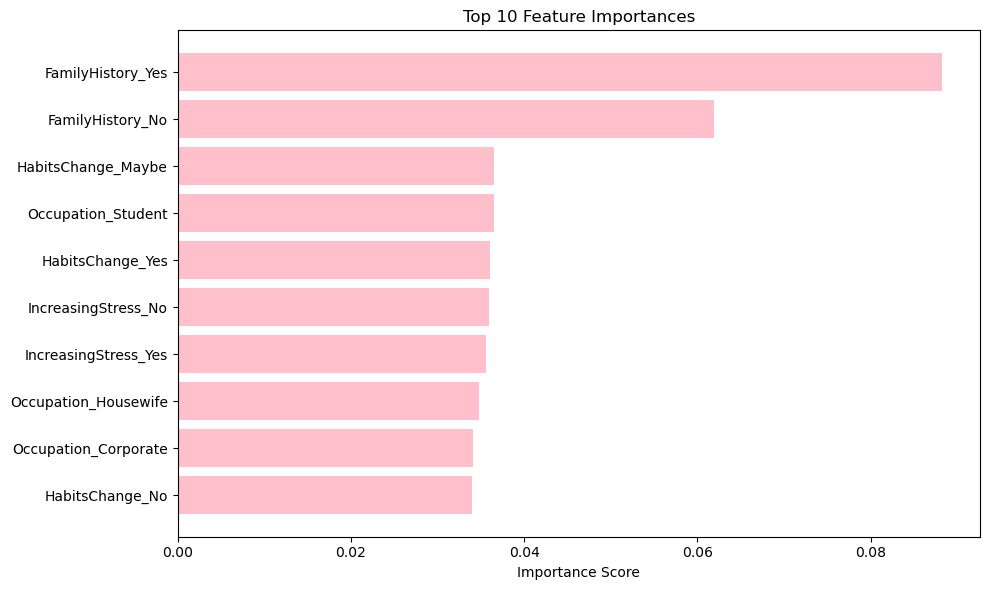

In [41]:
# Random Forest Information
importances = rfc.feature_importances_
feature_names = df_ef.columns.to_list()
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.barh(range(10), importances[indices][:10], color='pink')
plt.yticks(range(10), [feature_names[i] for i in indices[:10]])
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [12]:
# Tree Explainer
#explainer = shap.TreeExplainer(rfc)
#shap_values = explainer.shap_values(X_test)
#shap.summary_plot(shap_values[1], X_test, plot_type="dot")

In [13]:
df_cols = df_ef.columns.to_list()
df_important = list(rfc.feature_importances_)
data_dict = {}
i = 0
for item in df_cols:
    data_dict[item] = df_important[i]
    i += 1
data_dict

{'Gender_Female': np.float64(0.013600614074561973),
 'Gender_Male': np.float64(0.010112957692168729),
 'Occupation_Business': np.float64(0.03279654793638901),
 'Occupation_Corporate': np.float64(0.03410878527356862),
 'Occupation_Housewife': np.float64(0.03472388359721566),
 'Occupation_Others': np.float64(0.02895872344538219),
 'Occupation_Student': np.float64(0.036459396465233385),
 'Country_Australia': np.float64(0.006817683789177725),
 'Country_Canada': np.float64(0.016949552192861792),
 'Country_India': np.float64(0.0055284738615092735),
 'Country_Ireland': np.float64(0.01681729646378267),
 'Country_Netherlands': np.float64(0.009031678438586606),
 'Country_South Africa': np.float64(0.0044752733958873005),
 'Country_Sweden': np.float64(0.0047152372743181625),
 'Country_UK': np.float64(0.01866369885360782),
 'Country_USA': np.float64(0.016644224858986364),
 'Country_infrequent_sklearn': np.float64(0.008014624775491383),
 'SelfEmployed_No': np.float64(0.013566144994783504),
 'SelfEmp

In [14]:
print(f"{data_dict['Occupation_Business']} {data_dict['Occupation_Corporate']} {data_dict['Occupation_Housewife']} {data_dict['Occupation_Others']} {data_dict['Occupation_Student']}")

0.03279654793638901 0.03410878527356862 0.03472388359721566 0.02895872344538219 0.036459396465233385


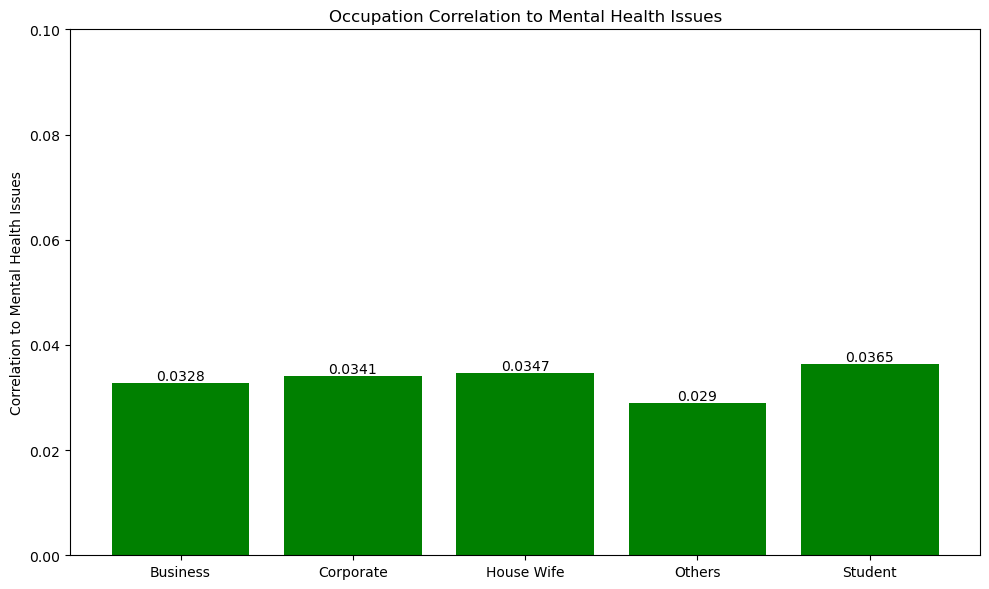

In [42]:
# Plot Occupation Correlation to Stress Data
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(['Business', 'Corporate', 'House Wife', 'Others', 'Student'], [data_dict['Occupation_Business'], data_dict['Occupation_Corporate'], data_dict['Occupation_Housewife'], data_dict['Occupation_Others'],data_dict['Occupation_Student']], color='green')
ax.set_title("Occupation Correlation to Mental Health Issues")
#plt.bar(['Business', 'Corporate', 'House Wife', 'Others', 'Student'], [data_dict['Occupation_Business'], data_dict['Occupation_Corporate'], data_dict['Occupation_Housewife'], data_dict['Occupation_Others'],data_dict['Occupation_Student']])
ax.set_ylim(0,0.1)
plt.ylabel("Correlation to Mental Health Issues")
plt.tight_layout()
for i, bar in enumerate(bars):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), va='bottom', ha='center')
plt.show()